# 1. モジュールインポート

In [46]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from modules.constants import Master
from modules.constants import LocalPaths
from modules.constants import HorseResultsCols
from modules.constants import ResultsCols
from modules import preparing
from modules import preprocessing
from modules import training
from modules import simulation
from modules import policies
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [4]:
%autoreload

In [7]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2020 = preparing.scrape_kaisai_date(from_="2010-01-01", to_="2024-05-22")
len(kaisai_date_2020)

getting race date from 2010-01-01 to 2024-05-22


  0%|          | 0/172 [00:00<?, ?it/s]

1551

In [8]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2020)
len(race_id_list)

getting race_id_list


  0%|          | 0/1551 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100109
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100110
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100111
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100116
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100117
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100123
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100124
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100130
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100131
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100206
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100207
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20100213
scraping: ht

49564

## 2.2. /race/ディレクトリのデータ取得

In [9]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/49564 [00:00<?, ?it/s]

race_id 201106010604 skipped. This page is not valid.
race_id 201408020304 skipped. This page is not valid.
race_id 201405010404 skipped. This page is not valid.
race_id 201405010508 skipped. This page is not valid.
race_id 201805010304 skipped. This page is not valid.
race_id 202006010101 skipped
race_id 202006010102 skipped
race_id 202006010103 skipped
race_id 202006010104 skipped
race_id 202006010105 skipped
race_id 202006010106 skipped
race_id 202006010107 skipped
race_id 202006010108 skipped
race_id 202006010109 skipped
race_id 202006010110 skipped
race_id 202006010111 skipped
race_id 202006010112 skipped
race_id 202008010101 skipped
race_id 202008010102 skipped
race_id 202008010103 skipped
race_id 202008010104 skipped
race_id 202008010105 skipped
race_id 202008010106 skipped
race_id 202008010107 skipped
race_id 202008010108 skipped
race_id 202008010109 skipped
race_id 202008010110 skipped
race_id 202008010111 skipped
race_id 202008010112 skipped
race_id 202006010201 skipped
race_

['/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010101.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010102.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010103.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010104.bin',
 '/home/hinata/code/HinataMikami/keibaAI-v2-main/data/html/race/201006010105.bin']

In [10]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

preparing raw results table


  0%|          | 0/34535 [00:00<?, ?it/s]

preparing raw race_info table


  0%|          | 0/34535 [00:00<?, ?it/s]

preparing raw return table


  0%|          | 0/34535 [00:00<?, ?it/s]

In [11]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.3. /horse/ディレクトリのデータ取得

In [12]:
%autoreload

In [14]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

scraping


  0%|          | 0/53280 [00:00<?, ?it/s]

horse_id 2007102719 skipped
horse_id 2007104474 skipped
horse_id 2007104533 skipped
horse_id 2007101891 skipped
horse_id 2007106506 skipped
horse_id 2007100239 skipped
horse_id 2007101725 skipped
horse_id 2007101308 skipped
horse_id 2007105515 skipped
horse_id 2007105022 skipped
horse_id 2007104590 skipped
horse_id 2007101832 skipped
horse_id 2007106483 skipped
horse_id 2007105314 skipped
horse_id 2007105979 skipped
horse_id 2007104211 skipped
horse_id 2007102771 skipped
horse_id 2007102232 skipped
horse_id 2007103403 skipped
horse_id 2007109164 skipped
horse_id 2007102006 skipped
horse_id 2007104937 skipped
horse_id 2007103482 skipped
horse_id 2007102898 skipped
horse_id 2007101473 skipped
horse_id 2007102601 skipped
horse_id 2007103711 skipped
horse_id 2007104292 skipped
horse_id 2007104680 skipped
horse_id 2007100843 skipped
horse_id 2007104454 skipped
horse_id 2007103847 skipped
horse_id 2007104973 skipped
horse_id 2007101560 skipped
horse_id 2007110103 skipped
horse_id 2007106491 

In [15]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

31730

In [22]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

"""target_date = '2022-06-25' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]"""

  0%|          | 0/11561 [00:00<?, ?it/s]

['/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017101445.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017109028.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016100106.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2015104412.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016105305.bin']

In [16]:
# 馬の基本情報テーブルの作成
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

preparing raw horse_info table


  0%|          | 0/31730 [00:00<?, ?it/s]

In [17]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new)

In [18]:
#　馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

preparing raw horse_results table


  0%|          | 0/31730 [00:00<?, ?it/s]

In [19]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

## 2.4. /ped/ディレクトリのデータ取得

In [24]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/53280 [00:00<?, ?it/s]

horse_id 2007102719 skipped
horse_id 2007104474 skipped
horse_id 2007104533 skipped
horse_id 2007101891 skipped
horse_id 2007106506 skipped
horse_id 2007100239 skipped
horse_id 2007101725 skipped
horse_id 2007101308 skipped
horse_id 2007105515 skipped
horse_id 2007105022 skipped
horse_id 2007104590 skipped
horse_id 2007101832 skipped
horse_id 2007106483 skipped
horse_id 2007105314 skipped
horse_id 2007105979 skipped
horse_id 2007104211 skipped
horse_id 2007102771 skipped
horse_id 2007102232 skipped
horse_id 2007103403 skipped
horse_id 2007109164 skipped
horse_id 2007102006 skipped
horse_id 2007104937 skipped
horse_id 2007103482 skipped
horse_id 2007102898 skipped
horse_id 2007101473 skipped
horse_id 2007102601 skipped
horse_id 2007103711 skipped
horse_id 2007104292 skipped
horse_id 2007104680 skipped
horse_id 2007100843 skipped
horse_id 2007104454 skipped
horse_id 2007103847 skipped
horse_id 2007104973 skipped
horse_id 2007101560 skipped
horse_id 2007110103 skipped
horse_id 2007106491 

In [25]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

preparing raw peds table


  0%|          | 0/7173 [00:00<?, ?it/s]

# 3. データ加工

In [2]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。
%autoreload

In [3]:
#前処理
results_processor = preprocessing.ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = preprocessing.RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = preprocessing.ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

              着順  枠番  馬番         馬名  性齢    斤量    騎手     タイム     着差     単勝  \
202006010101   1   4   7  オイデヤスダイジン  牝3  54.0  伊藤工真  1:13.3    NaN    3.6   
202006010101   2   1   1      グルアーブ  牝3  54.0  柴田善臣  1:13.3     クビ   17.2   
202006010101   3   2   3  トーレスデルパイネ  牝3  54.0  岩部純二  1:13.7  2.1/2  199.0   
202006010101   4   3   6      デュープス  牝3  54.0  武士沢友  1:13.8     クビ   50.4   
202006010101   5   6  12    ディヴィニティ  牝3  54.0  マーフィ  1:13.8     クビ    1.6   
...           ..  ..  ..        ...  ..   ...   ...     ...    ...    ...   
201909050912  12   5   9   キラーコンテンツ  牡5  57.0  北村友一  1:10.4    3/4   11.5   
201909050912  13   2   4   スカイパッション  牝7  55.0  藤懸貴志  1:10.5    1/2  294.0   
201909050912  14   5  10   ラフィングマッチ  牡4  57.0  太宰啓介  1:10.7  1.1/4  114.8   
201909050912  15   7  14    フェルトベルク  牝5  55.0  団野大成  1:11.0  1.3/4  115.2   
201909050912   0   1   2   クインズチャパラ  牝4  55.0  藤岡佑介     NaN    NaN    ---   

                人気      馬体重       調教師    horse_id jockey_id trainer_id  \
2

/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_horse_results_processor.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[Cols.PRIZE].fillna(0, inplace=True)


馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [4]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF, 
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = preprocessing.DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

separating horse results by date


  0%|          | 0/1551 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1551 [00:00<?, ?it/s]

In [5]:
#カテゴリ変数の処理
feature_enginnering = preprocessing.FeatureEngineering(data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_feature_engineering.py:102: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_target_master = pd.concat([target_master, new_target]).set_index(target_col)['encoded_id']
/home/hinata/code/HinataMikami/keibaAI-v2-main/modules/preprocessing/_feature_engi

In [6]:
#保存
#tmpは一時保存用のディレクトリ
feature_enginnering.featured_data.to_pickle('data/tmp/featured_data_20240525.pickle')

# 4. 学習

In [7]:
keiba_ai = training.KeibaAIFactory.create(feature_enginnering.featured_data) #モデル作成
keiba_ai.train_with_tuning() #パラメータチューニングをして学習

[I 2024-05-25 13:44:18,449] A new study created in memory with name: no-name-412b7e88-ea64-4c46-93e1-fc4ef19e1aed
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


feature_fraction, val_score: 0.448402:  14%|#4        | 1/7 [00:28<02:53, 28.97s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451654	valid_1's binary_logloss: 0.44993


feature_fraction, val_score: 0.448402:  29%|##8       | 2/7 [00:56<02:21, 28.22s/it]

Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.445275	valid_1's binary_logloss: 0.44883
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451694	valid_1's binary_logloss: 0.450702


feature_fraction, val_score: 0.448402:  43%|####2     | 3/7 [01:20<01:44, 26.18s/it]

Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.445711	valid_1's binary_logloss: 0.44934
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451588	valid_1's binary_logloss: 0.450014


feature_fraction, val_score: 0.448402:  57%|#####7    | 4/7 [01:47<01:20, 26.68s/it]

Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.447197	valid_1's binary_logloss: 0.449356
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.45168	valid_1's binary_logloss: 0.450052


feature_fraction, val_score: 0.448402:  71%|#######1  | 5/7 [02:12<00:51, 25.82s/it]

Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.448169	valid_1's binary_logloss: 0.449098
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451388	valid_1's binary_logloss: 0.450258


feature_fraction, val_score: 0.448402:  86%|########5 | 6/7 [02:36<00:25, 25.20s/it]

Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.443373	valid_1's binary_logloss: 0.449318
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452344	valid_1's binary_logloss: 0.450756


feature_fraction, val_score: 0.448402: 100%|##########| 7/7 [02:57<00:00, 25.37s/it]


Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.44691	valid_1's binary_logloss: 0.449355


num_leaves, val_score: 0.448402:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:   5%|5         | 1/20 [00:22<06:59, 22.09s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.425656	valid_1's binary_logloss: 0.449599
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.438719	valid_1's binary_logloss: 0.449206


num_leaves, val_score: 0.448402:  10%|#         | 2/20 [00:43<06:29, 21.65s/it]

Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.435618	valid_1's binary_logloss: 0.449056
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  15%|#5        | 3/20 [01:05<06:11, 21.84s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.43203	valid_1's binary_logloss: 0.44892
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  20%|##        | 4/20 [01:29<06:03, 22.73s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.407577	valid_1's binary_logloss: 0.450449
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  25%|##5       | 5/20 [01:53<05:48, 23.25s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.405888	valid_1's binary_logloss: 0.451389
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.481919	valid_1's binary_logloss: 0.478956
[200]	valid_0's binary_logloss: 0.477869	valid_1's binary_logloss: 0.47413
[300]	valid_0's binary_logloss: 0.475974	valid_1's binary_logloss: 0.471527
[400]	valid_0's binary_logloss: 0.474739

num_leaves, val_score: 0.448402:  30%|###       | 6/20 [02:33<06:44, 28.88s/it]

Early stopping, best iteration is:
[650]	valid_0's binary_logloss: 0.472766	valid_1's binary_logloss: 0.467155
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.410993	valid_1's binary_logloss: 0.449919


num_leaves, val_score: 0.448402:  35%|###5      | 7/20 [02:58<05:58, 27.57s/it]

Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.410239	valid_1's binary_logloss: 0.449697
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.466243	valid_1's binary_logloss: 0.458077
[200]	valid_0's binary_logloss: 0.460242	valid_1's binary_logloss: 0.453223
[300]	valid_0's binary_logloss: 0.456442	valid_1's binary_logloss: 0.451356
[400]	valid_0's binary_logloss: 0.4536

num_leaves, val_score: 0.448402:  40%|####      | 8/20 [03:34<06:04, 30.36s/it]

Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.452835	valid_1's binary_logloss: 0.45032
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  45%|####5     | 9/20 [03:58<05:12, 28.37s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.413261	valid_1's binary_logloss: 0.449931
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.442997	valid_1's binary_logloss: 0.449293


num_leaves, val_score: 0.448402:  50%|#####     | 10/20 [04:19<04:21, 26.16s/it]

Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.44067	valid_1's binary_logloss: 0.448996
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  55%|#####5    | 11/20 [04:42<03:45, 25.04s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.419493	valid_1's binary_logloss: 0.450283
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  60%|######    | 12/20 [05:05<03:14, 24.35s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.425998	valid_1's binary_logloss: 0.449892
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.442997	valid_1's binary_logloss: 0.449293


num_leaves, val_score: 0.448402:  65%|######5   | 13/20 [05:29<02:51, 24.47s/it]

Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.44067	valid_1's binary_logloss: 0.448996
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.431988	valid_1's binary_logloss: 0.449045


num_leaves, val_score: 0.448402:  70%|#######   | 14/20 [05:54<02:26, 24.41s/it]

Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.426819	valid_1's binary_logloss: 0.448894
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.431051	valid_1's binary_logloss: 0.449455


num_leaves, val_score: 0.448402:  75%|#######5  | 15/20 [06:17<02:00, 24.16s/it]

Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.4271	valid_1's binary_logloss: 0.449125
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  80%|########  | 16/20 [06:41<01:35, 23.99s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.420546	valid_1's binary_logloss: 0.449935
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.432647	valid_1's binary_logloss: 0.449111


num_leaves, val_score: 0.448402:  85%|########5 | 17/20 [07:05<01:12, 24.02s/it]

Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.425885	valid_1's binary_logloss: 0.448837
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452155	valid_1's binary_logloss: 0.450176


num_leaves, val_score: 0.448402:  90%|######### | 18/20 [07:28<00:47, 23.70s/it]

Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.448503	valid_1's binary_logloss: 0.449009
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.448402:  95%|#########5| 19/20 [07:52<00:23, 23.81s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.415416	valid_1's binary_logloss: 0.449941
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.424059	valid_1's binary_logloss: 0.448926


num_leaves, val_score: 0.448402: 100%|##########| 20/20 [08:15<00:00, 24.80s/it]


Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.421259	valid_1's binary_logloss: 0.448849


bagging, val_score: 0.448402:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452702	valid_1's binary_logloss: 0.452326


bagging, val_score: 0.448402:  10%|#         | 1/10 [00:19<02:57, 19.76s/it]

Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.45047	valid_1's binary_logloss: 0.451512
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451726	valid_1's binary_logloss: 0.451437


bagging, val_score: 0.448402:  20%|##        | 2/10 [00:42<02:53, 21.71s/it]

Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.444883	valid_1's binary_logloss: 0.449719
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452324	valid_1's binary_logloss: 0.450557


bagging, val_score: 0.448402:  30%|###       | 3/10 [01:06<02:36, 22.37s/it]

Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.446649	valid_1's binary_logloss: 0.449349
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452753	valid_1's binary_logloss: 0.45332


bagging, val_score: 0.448402:  40%|####      | 4/10 [01:26<02:09, 21.58s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.448165	valid_1's binary_logloss: 0.452525
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452178	valid_1's binary_logloss: 0.451313


bagging, val_score: 0.448402:  50%|#####     | 5/10 [01:46<01:45, 21.19s/it]

Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.447686	valid_1's binary_logloss: 0.45007
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452275	valid_1's binary_logloss: 0.451101


bagging, val_score: 0.448402:  60%|######    | 6/10 [02:09<01:26, 21.53s/it]

Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.443872	valid_1's binary_logloss: 0.4495
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452281	valid_1's binary_logloss: 0.45112


bagging, val_score: 0.448402:  70%|#######   | 7/10 [02:29<01:03, 21.25s/it]

Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.446097	valid_1's binary_logloss: 0.449525
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452354	valid_1's binary_logloss: 0.4505


bagging, val_score: 0.448402:  80%|########  | 8/10 [02:51<00:42, 21.42s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.444775	valid_1's binary_logloss: 0.448915
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451745	valid_1's binary_logloss: 0.449887


bagging, val_score: 0.448402:  90%|######### | 9/10 [03:15<00:22, 22.29s/it]

Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.444495	valid_1's binary_logloss: 0.448868
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452721	valid_1's binary_logloss: 0.452243


bagging, val_score: 0.448402: 100%|##########| 10/10 [03:39<00:00, 21.91s/it]


Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.44929	valid_1's binary_logloss: 0.451393


feature_fraction_stage2, val_score: 0.448402:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451979	valid_1's binary_logloss: 0.450363


feature_fraction_stage2, val_score: 0.448402:  17%|#6        | 1/6 [00:25<02:06, 25.24s/it]

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.444934	valid_1's binary_logloss: 0.449196
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451896	valid_1's binary_logloss: 0.450339
[200]	valid_0's binary_logloss: 0.441977	valid_1's binary_logloss: 0.448833


feature_fraction_stage2, val_score: 0.448402:  33%|###3      | 2/6 [00:50<01:41, 25.40s/it]

Early stopping, best iteration is:
[194]	valid_0's binary_logloss: 0.442504	valid_1's binary_logloss: 0.448789
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452071	valid_1's binary_logloss: 0.449872


feature_fraction_stage2, val_score: 0.448402:  50%|#####     | 3/6 [01:14<01:13, 24.51s/it]

Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.444377	valid_1's binary_logloss: 0.448465
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452278	valid_1's binary_logloss: 0.45091
[200]	valid_0's binary_logloss: 0.442299	valid_1's binary_logloss: 0.448876


feature_fraction_stage2, val_score: 0.448402:  67%|######6   | 4/6 [01:38<00:48, 24.36s/it]

Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.44064	valid_1's binary_logloss: 0.44873
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452157	valid_1's binary_logloss: 0.45012


feature_fraction_stage2, val_score: 0.448402:  83%|########3 | 5/6 [01:59<00:23, 23.07s/it]

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.449878	valid_1's binary_logloss: 0.44949
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452065	valid_1's binary_logloss: 0.450877


feature_fraction_stage2, val_score: 0.448402: 100%|##########| 6/6 [02:22<00:00, 23.76s/it]


Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.446009	valid_1's binary_logloss: 0.449647


regularization_factors, val_score: 0.448402:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:   5%|5         | 1/20 [00:23<07:32, 23.84s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448403
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  10%|#         | 2/20 [00:46<06:57, 23.18s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  15%|#5        | 3/20 [01:10<06:36, 23.35s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448403
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  20%|##        | 4/20 [01:33<06:10, 23.18s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  25%|##5       | 5/20 [01:56<05:49, 23.30s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  30%|###       | 6/20 [02:19<05:23, 23.14s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448403
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  35%|###5      | 7/20 [02:42<05:01, 23.22s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448402:  40%|####      | 8/20 [03:07<04:45, 23.80s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448403
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  45%|####5     | 9/20 [03:30<04:18, 23.47s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448401
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  50%|#####     | 10/20 [03:53<03:52, 23.25s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  55%|#####5    | 11/20 [04:16<03:28, 23.21s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  60%|######    | 12/20 [04:47<03:25, 25.67s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  65%|######5   | 13/20 [05:11<02:54, 24.98s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  70%|#######   | 14/20 [05:33<02:25, 24.17s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.446083	valid_1's binary_logloss: 0.448586
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  75%|#######5  | 15/20 [05:57<02:00, 24.00s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448404
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452018	valid_1's binary_logloss: 0.449996


regularization_factors, val_score: 0.448401:  80%|########  | 16/20 [06:20<01:35, 23.92s/it]

Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.446566	valid_1's binary_logloss: 0.448625
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  85%|########5 | 17/20 [06:46<01:13, 24.36s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448403
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  90%|######### | 18/20 [07:10<00:48, 24.43s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401:  95%|#########5| 19/20 [07:34<00:24, 24.22s/it]

Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448403
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452037	valid_1's binary_logloss: 0.449931


regularization_factors, val_score: 0.448401: 100%|##########| 20/20 [07:58<00:00, 23.92s/it]


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.444491	valid_1's binary_logloss: 0.448402


min_child_samples, val_score: 0.448401:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451948	valid_1's binary_logloss: 0.450527


min_child_samples, val_score: 0.448401:  20%|##        | 1/5 [00:24<01:37, 24.25s/it]

Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.447938	valid_1's binary_logloss: 0.449622
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452186	valid_1's binary_logloss: 0.450035


min_child_samples, val_score: 0.448365:  40%|####      | 2/5 [00:51<01:18, 26.27s/it]

Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 0.444019	valid_1's binary_logloss: 0.448365
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.45194	valid_1's binary_logloss: 0.450079


min_child_samples, val_score: 0.448365:  60%|######    | 3/5 [01:14<00:49, 24.70s/it]

Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.446087	valid_1's binary_logloss: 0.448776
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.451945	valid_1's binary_logloss: 0.45017


min_child_samples, val_score: 0.448365:  80%|########  | 4/5 [01:56<00:31, 31.24s/it]

Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.446385	valid_1's binary_logloss: 0.448988
[LightGBM] [Info] Number of positive: 72904, number of negative: 278315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25972
[LightGBM] [Info] Number of data points in the train set: 351219, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207574 -> initscore=-1.339610
[LightGBM] [Info] Start training from score -1.339610
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452163	valid_1's binary_logloss: 0.449873
[200]	valid_0's binary_logloss: 0.442816	valid_1's binary_logloss: 0.448067


min_child_samples, val_score: 0.448042: 100%|##########| 5/5 [02:21<00:00, 28.34s/it]

Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.442429	valid_1's binary_logloss: 0.448042


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.484574685651904e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.484574685651904e-07
[LightGBM] [Warning] lambda_l1 is set=1.2727710718417932e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2727710718417932e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.484574685651904e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.484574685651904e-07
[LightGBM] [Warning] lambda_l1 is set=1.2727710718417932e-07, reg_alpha=0.0 will be ignored. Current value

In [8]:
#特徴量の重要度
keiba_ai.feature_importance()

,features,importance
4,jockey_id,366
3,horse_id,152
5,trainer_id,148
8,体重,132
10,n_horses,95
6,owner_id,94
7,年齢,94
184,age_days,88
9,体重変化,77
11,course_len,73


In [9]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 100,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 1.2727710718417932e-07,
 'lambda_l2': 2.484574685651904e-07,
 'feature_fraction': 0.5,
 'bagging_fraction': 1.0,
 'bagging_freq': 0}

In [26]:
#チューニングしないで学習
#keiba_ai.train_without_tuning()

AUC: 0.826(train), 0.648(test)


In [10]:
#モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
training.KeibaAIFactory.save(keiba_ai, version_name='basemodel_20101-20245')

In [13]:
#モデルロード
keiba_ai = training.KeibaAIFactory.load('models/20240525/basemodel_20101-20245.pickle')
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [14]:
%autoreload

In [15]:
#シミュレーターに馬券をセット
simulator = simulation.Simulator(return_processor)

In [16]:
# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, policies.StdScorePolicy)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.484574685651904e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.484574685651904e-07
[LightGBM] [Warning] lambda_l1 is set=1.2727710718417932e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2727710718417932e-07
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [17]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyTansho, # 賭け方の方針
                threshold=threshold #「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/tansho.pickle')

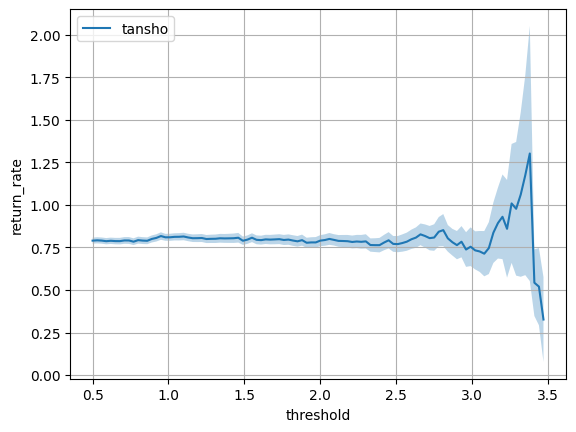

In [20]:
#回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='tansho')

### 5.1.2 複勝馬券

In [21]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyFukusho, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/fukusho.pickle')

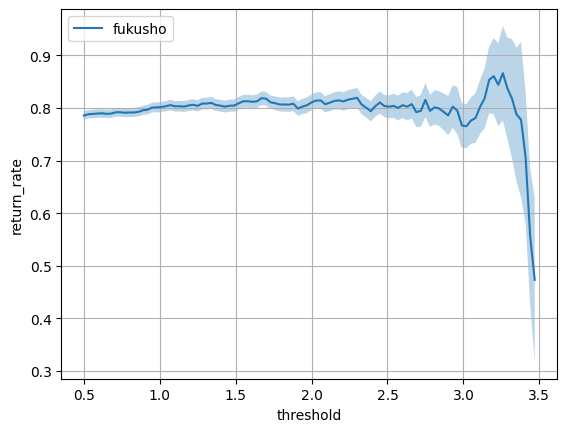

In [23]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='fukusho')

### 5.1.3 馬連BOX

In [24]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmarenBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/umarenbox.pickle')

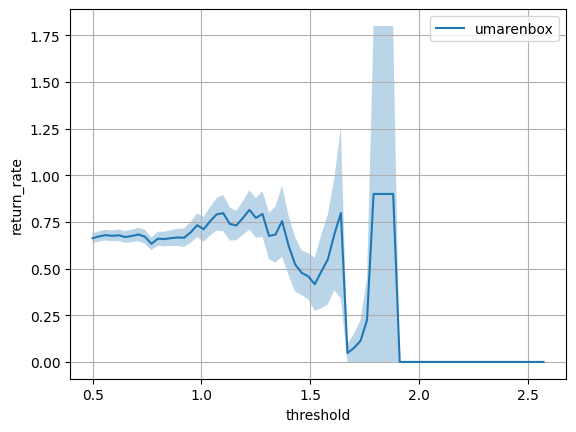

In [26]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umarenbox')

### 5.1.4 馬単BOX

In [27]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmatanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/umatanbox.pickle')

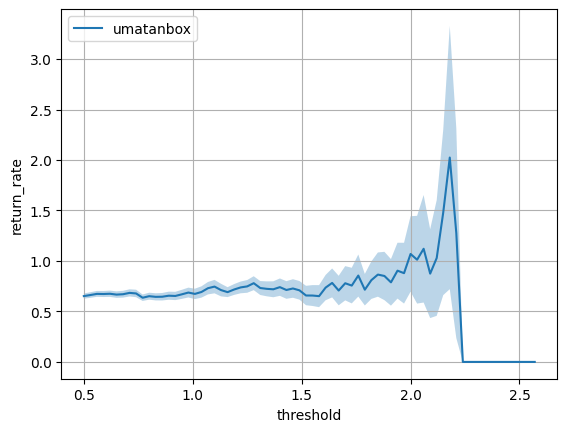

In [29]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umatanbox')

### 5.1.5 ワイドBOX

In [30]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyWideBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/widebox.pickle')

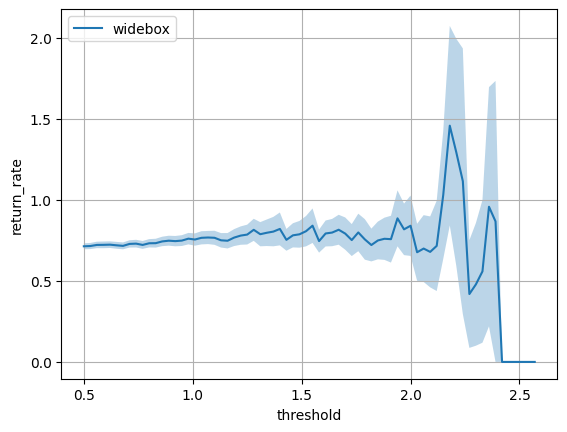

In [32]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='widebox')

### 5.1.6 三連複BOX

In [33]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrenpukuBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/sanrenpukubox.pickle')

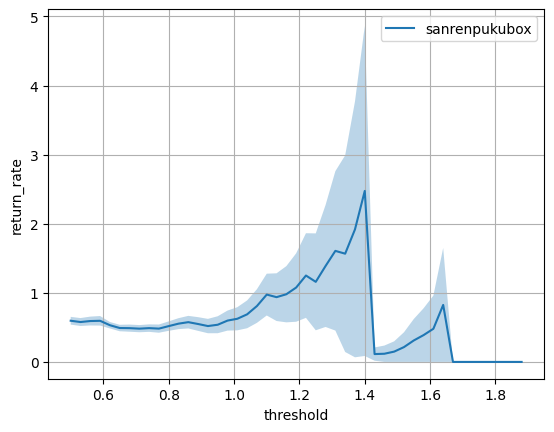

In [35]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrenpukubox')

### 5.1.7 三連単BOX

In [36]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrentanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240525/sanrentanbox.pickle')

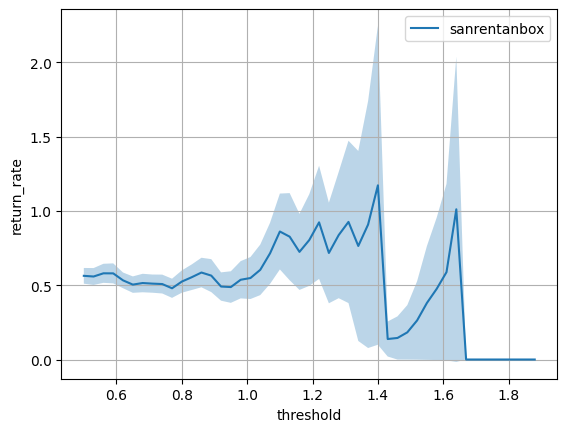

In [38]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrentanbox')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [274]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    score_table, # スコアテーブル
                    policies.BetPolicyTanshoFukusho, # 賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

  0%|          | 0/10 [00:00<?, ?it/s]

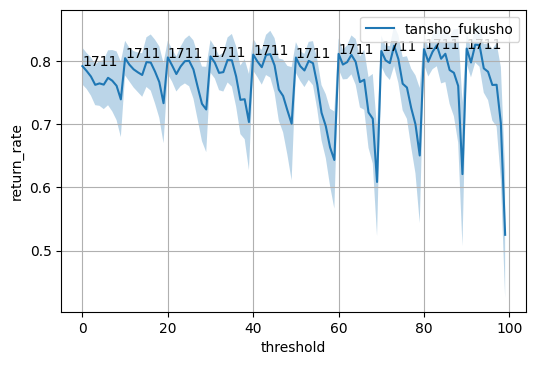

In [273]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [52]:
%autoreload

In [48]:
race_id_list = preparing.scrape_race_id_list(['20240525']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20240525


24

In [53]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

345

In [54]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

scraping


  0%|          | 0/345 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#horse_infoテーブルの更新
horse_info_20220108 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20220108)

In [ ]:
#horse_resultsテーブルの更新
horse_results_20220108 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20220108)

In [ ]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True)
peds_20220108 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20220108)

In [ ]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

In [ ]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20240525/basemodel_20101-20245.pickle')

## 6.2. 前日全レース予想

In [ ]:
%autoreload

In [ ]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20221001')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2024/05/25'

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        # 前日予想の場合、馬体重を0（0）に補正
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        # 前日予想の場合、天候と馬場状態が公開されていない場合はこちらを有効にする
        #pd2['weather'] = '晴'
        #pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.3. レース直前データ処理（当日レース予想）

In [28]:
%autoreload

In [ ]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()
print((target_race_id_list))
print((target_race_time_list))

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.4. レース直前データ処理（旧方式）

In [ ]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2022/1/8', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [30]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [32]:
#予測
X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)
keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False)

,馬番,単勝,score
202206010201,5,4.7,1.972623
202206010201,3,4.3,1.698477
202206010201,15,4.5,1.292167
202206010201,4,5.7,0.754306
202206010201,11,5.4,0.706008
202206010201,6,16.9,0.401887
202206010201,16,14.2,-0.070303
202206010201,1,26.7,-0.260754
202206010201,13,29.8,-0.300251
202206010201,9,101.3,-0.481400
